In [1]:
import numpy as np
import pandas as pd
import cv2 
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import math
import gc
import torch.cuda

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = '../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/annotations/manual/PHOENIX-2014-T.train-complex-annotation.corpus.csv'
dataframe = pd.read_csv(path, sep='|')
dataframe.head(5)

,name,video,start,end,speaker,orth,translation
0,11August_2010_Wednesday_tagesschau-1,11August_2010_Wednesday_tagesschau-1/1/*.png,-1,-1,Signer08,__ON__ JETZT WETTER MORGEN DONNERSTAG ZWOELF F...,und nun die wettervorhersage für morgen donner...
1,11August_2010_Wednesday_tagesschau-4,11August_2010_Wednesday_tagesschau-4/1/*.png,-1,-1,Signer08,ORT-PLUSPLUS REGEN DURCH REGEN-PLUSPLUS KOENNE...,mancherorts regnet es auch länger und ergiebig...
2,11August_2010_Wednesday_tagesschau-5,11August_2010_Wednesday_tagesschau-5/1/*.png,-1,-1,Signer08,__ON__ loc-NORDWEST HEUTE NACHT TROCKEN BLEIBE...,im nordwesten bleibt es heute nacht meist troc...
3,11August_2010_Wednesday_tagesschau-6,11August_2010_Wednesday_tagesschau-6/1/*.png,-1,-1,Signer08,TAGSUEBER OFT REGEN-PLUSPLUS GEWITTER GEWITTER...,auch am tag gibt es verbreitet zum teil kräfti...
4,11August_2010_Wednesday_tagesschau-7,11August_2010_Wednesday_tagesschau-7/1/*.png,-1,-1,Signer08,__ON__ WOLKE LOCH LOCH SPEZIELL loc-NORDWEST _...,größere wolkenlücken finden sich vor allem im ...


In [4]:
dataframe.tail(10)

,name,video,start,end,speaker,orth,translation
7086,27January_2013_Sunday_tagesschau-8827,27January_2013_Sunday_tagesschau-8827/1/*.png,-1,-1,Signer01,__ON__ MONTAG MORGEN ACHT ZWANZIG JANUAR __OFF__,und nun die wettervorhersage für morgen montag...
7087,27January_2013_Sunday_tagesschau-8830,27January_2013_Sunday_tagesschau-8830/1/*.png,-1,-1,Signer01,__ON__ IN-KOMMEND WARM WIE PASSEN FRUEHLING NU...,in den nächsten tagen dann bei fast schon früh...
7088,27January_2013_Sunday_tagesschau-8831,27January_2013_Sunday_tagesschau-8831/1/*.png,-1,-1,Signer01,__ON__ HEUTE NACHT REGION SCHNEE SCHNEE REGEN ...,heute nacht gibt es im osten und süden noch sc...
7089,27January_2013_Sunday_tagesschau-8832,27January_2013_Sunday_tagesschau-8832/1/*.png,-1,-1,Signer01,__ON__ BESONDERS NORD NORDWESTRAUM WOLKE VERSC...,vor allem im norden und westen klart es gebiet...
7090,27January_2013_Sunday_tagesschau-8837,27January_2013_Sunday_tagesschau-8837/1/*.png,-1,-1,Signer01,MORGEN TATSAECHLICH FROST negalp-KEIN EINS __H...,morgen seit längerem wieder frostfrei ein grad...
7091,27January_2013_Sunday_tagesschau-8838,27January_2013_Sunday_tagesschau-8838/1/*.png,-1,-1,Signer01,__ON__ DIENSTAG WIND STARK __HOLD__ REGEN __LE...,am dienstag wird es sehr windig und es regnet ...
7092,27January_2013_Sunday_tagesschau-8839,27January_2013_Sunday_tagesschau-8839/1/*.png,-1,-1,Signer01,MITTWOCH WIND MEHR REGEN REGEN __PU__,am mittwoch legt der wind noch zu und es regne...
7093,27January_2013_Sunday_tagesschau-8840,27January_2013_Sunday_tagesschau-8840/1/*.png,-1,-1,Signer01,SUED REGION __HOLD__ SONNE AUCH DABEI,im süden zeigt sich aber auch die sonne .
7094,27January_2013_Sunday_tagesschau-8841,27January_2013_Sunday_tagesschau-8841/1/*.png,-1,-1,Signer01,DONNERSTAG FREUNDLICH SONNE DANN SPAETER cl-KO...,der donnerstag beginnt oft freundlich später z...
7095,27January_2013_Sunday_tagesschau-8842,27January_2013_Sunday_tagesschau-8842/1/*.png,-1,-1,Signer01,__ON__ BLEIBEN WIND __OFF__,es bleibt windig .


In [5]:
np.unique(dataframe['speaker'].values)

array(['Signer01', 'Signer02', 'Signer03', 'Signer04', 'Signer05',
       'Signer06', 'Signer07', 'Signer08', 'Signer09'], dtype=object)

In [6]:
dataframe.drop(columns=['start', 'end'], inplace=True)

In [7]:
dataframe.head(10)

,name,video,speaker,orth,translation
0,11August_2010_Wednesday_tagesschau-1,11August_2010_Wednesday_tagesschau-1/1/*.png,Signer08,__ON__ JETZT WETTER MORGEN DONNERSTAG ZWOELF F...,und nun die wettervorhersage für morgen donner...
1,11August_2010_Wednesday_tagesschau-4,11August_2010_Wednesday_tagesschau-4/1/*.png,Signer08,ORT-PLUSPLUS REGEN DURCH REGEN-PLUSPLUS KOENNE...,mancherorts regnet es auch länger und ergiebig...
2,11August_2010_Wednesday_tagesschau-5,11August_2010_Wednesday_tagesschau-5/1/*.png,Signer08,__ON__ loc-NORDWEST HEUTE NACHT TROCKEN BLEIBE...,im nordwesten bleibt es heute nacht meist troc...
3,11August_2010_Wednesday_tagesschau-6,11August_2010_Wednesday_tagesschau-6/1/*.png,Signer08,TAGSUEBER OFT REGEN-PLUSPLUS GEWITTER GEWITTER...,auch am tag gibt es verbreitet zum teil kräfti...
4,11August_2010_Wednesday_tagesschau-7,11August_2010_Wednesday_tagesschau-7/1/*.png,Signer08,__ON__ WOLKE LOCH LOCH SPEZIELL loc-NORDWEST _...,größere wolkenlücken finden sich vor allem im ...
5,11August_2010_Wednesday_tagesschau-9,11August_2010_Wednesday_tagesschau-9/1/*.png,Signer08,FLUSS HEUTE NACHT SECHS FLUSS SIEBZEHN GRAD,im emsland heute nacht nur neun am oberrhein b...
6,11August_2010_Wednesday_tagesschau-10,11August_2010_Wednesday_tagesschau-10/1/*.png,Signer08,MORGEN TEMPERATUR GLEICH-WIE HEUTE NEUNZEHN BI...,morgen ähnliche temperaturen wie heute neunzeh...
7,11August_2010_Wednesday_tagesschau-11,11August_2010_Wednesday_tagesschau-11/1/*.png,Signer08,__ON__ FREITAG loc-OST KOENNEN REGEN REGEN STA...,am freitag kann es in der osthälfte teilweise ...
8,11August_2010_Wednesday_tagesschau-12,11August_2010_Wednesday_tagesschau-12/1/*.png,Signer08,loc-REGION WECHSELHAFT REGEN GEWITTER AUCH WOC...,sonst wechselhaft mit schauern und gewittern d...
9,11August_2010_Wednesday_tagesschau-13,11August_2010_Wednesday_tagesschau-13/1/*.png,Signer08,__ON__ TEMPERATUR BLEIBEN GLEICH __OFF__,am temperaturniveau ändert sich wenig .


In [8]:
dataframe['video'][0]

'11August_2010_Wednesday_tagesschau-1/1/*.png'

In [9]:
signer1_dataframe = dataframe[dataframe['speaker']=='Signer01']

In [10]:
signer1_dataframe.drop(columns=['speaker', 'video', 'translation'], inplace=True)

/miniconda3/envs/transformers/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
signer1_dataframe.head(10)

,name,orth
10,25October_2010_Monday_tagesschau-14,__ON__ __HOLD__ MORGEN WETTER WIE-AUSSEHEN DIE...
11,25October_2010_Monday_tagesschau-15,__ON__ ITALIEN IX TIEF DRUCK cl-KOMMEN HEUTE N...
12,25October_2010_Monday_tagesschau-16,__ON__ LANG ZEIT __LEFTHAND__ REGION HOCH cl-K...
13,25October_2010_Monday_tagesschau-18,__ON__ TAG MISCHUNG SONNE WOLKE KOENNEN NEBEL ...
14,25October_2010_Monday_tagesschau-19,WIND WEHEN WEHEN __LEFTHAND__ __OFF__ __ON__ A...
15,25October_2010_Monday_tagesschau-20,__ON__ HEUTE NACHT SECHS GRAD NORDRAUM MINUS S...
16,25October_2010_Monday_tagesschau-21,__ON__ DREI REGION DREI __HOLD__ ELF REGION __...
17,25October_2010_Monday_tagesschau-23,__ON__ REGION WOLKE NEBEL __LEFTHAND__ UND SON...
37,10March_2011_Thursday_heute-49,__ON__ GUT ABEND LIEB ZUSCHAUER poss-EUCH
38,10March_2011_Thursday_heute-50,WETTER WIND MORGEN VERSCHWINDEN DANN IN-KOMMEN...


In [12]:
signer1_dataframe.shape

(1862, 2)

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(signer1_dataframe['orth'], test_size = 0.2, random_state = 42)
val, test = train_test_split(test, test_size = 0.5, random_state = 42)
train.shape, test.shape, val.shape

((1489,), (187,), (186,))

In [14]:
np.array(signer1_dataframe['orth'])[:10]

array(['__ON__ __HOLD__ MORGEN WETTER WIE-AUSSEHEN DIENSTAG SECHS ZWANZIG OKTOBER __OFF__',
       '__ON__ ITALIEN IX TIEF DRUCK cl-KOMMEN HEUTE NACHT BERG SCHNEE REGEN REGEN __OFF__',
       '__ON__ LANG ZEIT __LEFTHAND__ REGION HOCH cl-KOMMEN OST cl-KOMMEN __HOLD__ SONST REGION DEUTSCH STARK RUHIG AUCH TEILWEISE FREUNDLICH SONNE __OFF__',
       '__ON__ TAG MISCHUNG SONNE WOLKE KOENNEN NEBEL SUEDOSTRAUM SUED NORD HABEN SCHAUER SCHAUER KOENNEN ABEND DANN NORDWESTRAUM BISSCHEN WOLKE cl-KOMMEN',
       'WIND WEHEN WEHEN __LEFTHAND__ __OFF__ __ON__ ABEND FRISCH WEHEN __OFF__',
       '__ON__ HEUTE NACHT SECHS GRAD NORDRAUM MINUS SECHS ALLGAEU REGION __OFF__',
       '__ON__ DREI REGION DREI __HOLD__ ELF REGION __OFF__',
       '__ON__ REGION WOLKE NEBEL __LEFTHAND__ UND SONNE __OFF__',
       '__ON__ GUT ABEND LIEB ZUSCHAUER poss-EUCH',
       'WETTER WIND MORGEN VERSCHWINDEN DANN IN-KOMMEND WOCHENENDE LANGSAM KOMMEN KOMMEN FRUEHLING BODEN BLUETE BLUETE VORHER WOLKE BRAUN __OFF__'],
    

## Tokenizer model

In [15]:
from torchnlp.encoders.text import StaticTokenizerEncoder, SpacyEncoder, pad_tensor
loaded_data = np.array(signer1_dataframe['orth'])
encoder = StaticTokenizerEncoder(loaded_data, tokenize=lambda s: s.split())

encoded_data = [encoder.encode(example) for example in loaded_data]
encoded_data = [pad_tensor(x, length=35) for x in encoded_data]

example_encode = encoder.encode(loaded_data[1])
example_pad = pad_tensor(example_encode, length=35)

# print(encoded_data[:10])

# print ()

print('actual: ', loaded_data[1])
print('encoded: ',example_pad)
print('decoded: ', encoder.decode(example_pad))


# encoder2 = SpacyEncoder(loaded_data)
# encoded_data2 = [encoder2.encode(example) for example in loaded_data]
# encoded_data2 = [pad_tensor(x, length=50)for x in encoded_data2]


# print (encoded_data2[:10])


# print('actual: ', loaded_data[1])
# print('encoded: ', encoder2.encode(loaded_data[1]))
# print('decoded: ', encoder2.decode(encoder2.encode(loaded_data[1])))

actual:  __ON__ ITALIEN IX TIEF DRUCK cl-KOMMEN HEUTE NACHT BERG SCHNEE REGEN REGEN __OFF__
encoded:  tensor([ 5, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
decoded:  __ON__ ITALIEN IX TIEF DRUCK cl-KOMMEN HEUTE NACHT BERG SCHNEE REGEN REGEN __OFF__ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## Spacy Tokenizer (Not in use)

In [16]:
# from spacy.tokenizer import Tokenizer
# from spacy.lang.de import German
# nlp = German()
# # Create a blank Tokenizer with just the English vocab
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [17]:
# import torchtext
# from torchtext.data.utils import get_tokenizer
# TEXT = torchtext.data.Field(tokenize = tokenizer,
# #                             tokenizer_language="de",
#                             init_token = '<sos>',
#                             eos_token = '<eos>',
#                             lower = True)

# TEXT.build_vocab(train)
# print (TEXT.vocab.itos)
# print (TEXT.vocab.stoi)

#train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
# TEXT.build_vocab(train_txt)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def batchify(data, bsz):
#     data = TEXT.numericalize([data.examples[0].text])
#     # Divide the dataset into bsz parts.
#     nbatch = data.size(0) // bsz
#     # Trim off any extra elements that wouldn't cleanly fit (remainders).
#     data = data.narrow(0, 0, nbatch * bsz)
#     # Evenly divide the data across the bsz batches.
#     data = data.view(bsz, -1).t().contiguous()
#     return data.to(device)

# batch_size = 20
# eval_batch_size = 10
# train_data = batchify(train_txt, batch_size)
# val_data = batchify(val_txt, eval_batch_size)
# test_data = batchify(test_txt, eval_batch_size)


# print(type(train_txt))

In [18]:
# NLP = spacy.load('de_core_news_lg')
# MAX_CHARS = 20000

# !python -m spacy download de_core_news_lg


In [19]:
import torchvision.models as models
from torchvision.transforms import transforms as T
from PIL import Image

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
image_path = '../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/01April_2010_Thursday_heute-6694/images0010.png'
image = Image.open(image_path)
image = transform(image)
image = image.view(1, 3, 224,224)


## Analysis of sequence sizes

In [35]:
m = 0
max_folder = ''
list_folders = []
list_len = []

for folder in os.listdir('../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/'):
    l = len(os.listdir('../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/' + folder))
    list_folders.append(folder)
    list_len.append(l)
        


In [21]:
#MAX
# print(m)

In [36]:
df = pd.DataFrame(list(zip(list_folders, list_len)), columns=['Folder', 'No. of images'])

In [23]:
# df

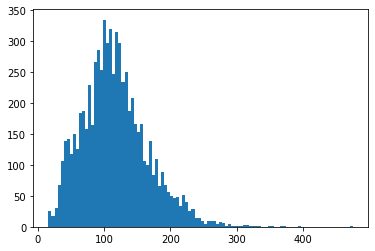

In [37]:
plt.hist(df['No. of images'], bins=100)
plt.show()

In [25]:
# signer1_dataframe

## Signer 1 alone

In [26]:
x = []
signer1_path = '../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/'
signer1 = signer1_dataframe.copy(deep=True)
for folder in tqdm(signer1['name']):
    if len(os.listdir(signer1_path + folder))>250:
        signer1_dataframe = signer1_dataframe[signer1_dataframe['name']!=folder]

signer1_train, signer1_test = train_test_split(signer1_dataframe, test_size=0.3, random_state=42)
signer1_test, signer1_val = train_test_split(signer1_test, test_size=0.5, random_state=42)

signer1_train.shape, signer1_test.shape, signer1_val.shape
        

100%|██████████| 1862/1862 [00:00<00:00, 10221.07it/s]


((1286, 2), (276, 2), (276, 2))

In [27]:
signer1_dataframe.shape

(1838, 2)

In [28]:
class SLRT_Signer(Dataset):
    """SLRT dataset."""

    def __init__(self, data_frame, root_dir, transform, tokenizer, pretrained_model):
        self.images_frame = data_frame['name']
        self.glosses = data_frame['orth']
        self.root_dir = root_dir
        self.transform = transform
        self.pretrained_model = pretrained_model
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.images_frame)

    def __getitem__(self, idx):
        global device
        if torch.is_tensor(idx):
            idx = idx.tolist()
        training_example = torch.zeros(250,1000)
        for files in os.listdir(os.path.join(self.root_dir, self.images_frame.iloc[idx])):
            img_name = self.root_dir + self.images_frame.iloc[idx] + '/' + files
            image = Image.open(img_name)
            image = self.transform(image)
            image = image.view(1, 3, 224,224)
#             image = image.to(device)
            vector = self.pretrained_model(image)
            training_example[0:len(files), :] = vector
            #can we preallocate tensor and add image encoding vector like tensor[:,0:image_size]
        gloss = self.glosses.iloc[idx]
        encoded_gloss = self.tokenizer.encode(gloss)
        encoded_gloss = pad_tensor(encoded_gloss, 250)
        #should we transform glosses to tokenized version before we form as training set??
        #gloss = torch.tensor([gloss])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        return training_example, encoded_gloss


modify exisiting class to iterate through different samples using dataloader below

In [30]:
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():    
    param.requires_grad = False
    
# model.to(device)
signer1_train_dataset = SLRT_Signer(signer1_train,
                   root_dir='../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/',
                   transform=transform,
                   tokenizer=encoder,
                   pretrained_model = model)
                  

signer1_test_dataset = SLRT_Signer(signer1_test,
                   root_dir='../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/',
                   transform=transform,
                   tokenizer=encoder,
                   pretrained_model = model)


signer1_val_dataset = SLRT_Signer(signer1_val,
                   root_dir='../PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/',
                   transform=transform,
                   tokenizer=encoder,
                   pretrained_model = model)
    
# print (signer1_dataset.__len__())



### Training Parameters

In [31]:
params = {'batch_size': 6,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 100

In [32]:
# Generators
train_gen = DataLoader(signer1_train_dataset, **params)
test_gen = DataLoader(signer1_test_dataset, **params)
# val_gen = DataLoader(signer1_val_dataset, **params)


In [33]:
# def _generate_square_subsequent_mask(self, src, trt, sz):
# #         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
# #         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
# #         print (src.shape)
#         mask = (torch.triu(torch.ones(sz, sz))==1).transpose(0,1)
#         nopeak_mask = (mask==1).to(device)
#         zeros = torch.zeros(1000).to(device)
        
#         target_msk = (trt[1] != 0).unsqueeze(1).to(device)
#         target_msk = target_msk & nopeak_mask
#         return src_msk, target_msk, nopeak_mask

In [34]:
# x = torch.tensor([[1,2,3],[4,5,6],[0,0,0]])
# print (x!=torch.tensor([0,0,0]).unsqueeze(0).transpose(0,1))

### Mobile Net Experimentation

In [34]:
# mobilenet_mod = models.mobilenet_v2(pretrained=True)
# for layer in mobilenet_mod.named_children():
#     print (layer)
# print (mobilenet_mod.classifier[1].out_features)

In [35]:
# class MobileNetFinalLayer(nn.Module):
#     def __init__(self, input_data, in_features, out_features, out_dim):
#         super (MobileNetFinalLayer, self).__init__()
#         self.mobilenet_model = models.mobilenet_v2(pretrained=True)
#         self.input_data = input_data
#         self.input_data_dim = input_data.shape
#         self.final_layer_features =  in_features
#         sefl.final_layer_linear = nn.Linear(in_features, out_features)

        
#     def forward()

# Transformer Model

In [36]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.tgt_mask = None
        self.nopeakmask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        #self.encoder = nn.Embedding(ntoken, ninp)
        self.decoder_embedding = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.softmax = nn.Softmax(1)
        
        self.init_weights()

    def _generate_square_subsequent_mask(self, src, trt, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         print (src.shape)
#         mask = (torch.triu(torch.ones(sz, sz))==1).transpose(0,1)
#         nopeak_mask = (mask==0).to(device)
#         nopeakmask = nn.Transformer.generate_square_subsequent_mask(self, sz).to(device)
        mask = (torch.triu(torch.ones(250, 250)) == 1).transpose(0, 1).half().to(device)
        nopeakmask = mask.float().half().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
        zeros = torch.zeros(1000).half().to(device)
        src_msk = (src == zeros).half().to(device)
        target_msk = (trt == 0).unsqueeze(0).half().to(device)
        #target_msk = target_msk & nopeak_mask
        return src_msk, target_msk, nopeakmask

    def init_weights(self):
        initrange = 0.1
        #self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, trt):
        
        if self.src_mask is None or self.src_mask.size(0) != src.size(0):
#             print (src.shape, trt.shape)
            device = src.device
            src_mask, tgt_mask, self.nopeakmask = self._generate_square_subsequent_mask(src, trt, src.size(1))
#             print (src_mask.shape, tgt_mask.shape, nopeakmask.shape)
            self.src_mask = src_mask
            #self.tgt_mask = tgt_mask
        #src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.permute(1,0,2)
        trgt = self.decoder_embedding(trt)
        trgt = trgt.permute(1,0,2)
#         print (trgt.shape), print (output.shape)
        output = self.transformer_decoder(trgt, output, tgt_mask = self.nopeakmask) #tgt_key_padding_mask = tgt_mask)
        output = self.decoder(output)
#         print (output.shape)  shape: 250, batchsize, 719
        output = output.permute(1,2,0)
        #output = output.reshape(-1, output.shape[2])
#         output = self.softmax(output)
        return output


In [37]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [38]:
ntokens = len(encoder.vocab) # the size of vocabulary
emsize = 1000 # embedding dimension
nhid = 500 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
src_pad_index = 0

In [39]:
#model training
transformer = TransformerModel(ntokens, emsize, nhid, nlayers,nhead, dropout).half().to(device)
criterion = nn.CrossEntropyLoss(ignore_index = src_pad_index)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
 # enumerate epochs
for epoch in range(10):
# enumerate mini batches
    epoch_loss = 0
    print ("Epoch: ", epoch, "in progress...")
    for i, (inputs, targets) in enumerate(train_gen):   
        inputs, targets = inputs.half().to(device), targets.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = transformer(inputs, targets) 8,250, 719
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
        del inputs, targets
        gc.collect()
    print ("Epoch {} : {}".format(epoch, epoch_loss))

In [40]:
# print(epoch, epoch_loss)

In [41]:
import torchtext

In [42]:
from torchtext.data.metrics import bleu_score


In [43]:
torch.save({
            'epoch': 10,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 448.1
            }, 'model-1.pt')

## Pretrained Model

In [44]:
eval_model  = TransformerModel(ntokens, emsize, nhid, nlayers,nhead, dropout).half().to(device)
# eval_model  = TransformerModel(ntokens, emsize, nhid, nlayers,nhead, dropout)

eval_optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

checkpoint = torch.load('model-1.pt')
eval_model.load_state_dict(checkpoint['model_state_dict'])
eval_optim.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss(ignore_index = src_pad_index)
eval_model.eval()


pass


In [45]:
epoch_loss = 0
for i, (inputs, targets) in tqdm(enumerate(test_gen)):   
    inputs, targets = inputs.half().to(device), targets.to(device)
#     inputs, targets = inputs, targets
    
    # clear the gradients
#     optimizer.zero_grad()
    # compute the model output
    yhat = eval_model(inputs, targets)
    # calculate loss
    loss = criterion(yhat, targets)
    
#     print(f"Batch {i+1}\nActual: {encoder.decode(targets.to(torch.device('cpu')).detach().numpy()[0])}\nPredicted: {encoder.decode(yhat.to(torch.device('cpu')).detach().numpy()[0])}")
#     print(f"Batch {i+1}\nActual: {encoder.decode(targets(0))}\nPredicted: {encoder.decode(yhat[0])}")
    
    # credit assignment
#     loss.backward()
    # update model weights
#     optimizer.step()
    epoch_loss += loss.item()
    torch.cuda.empty_cache()
    del inputs, targets
    gc.collect()
    
    
print ("Epoch {} : Batch Loss {}".format(1, epoch_loss))


In [47]:
# epoch_loss

In [48]:
280 / 33 * 46

390.30303030303025

In [63]:
epoch_loss = 0
for i, (inputs, targets) in tqdm(enumerate(test_gen)):   
    inputs, targets = inputs.half().to(device), targets.to(device)
#     inputs, targets = inputs, targets
    
    # clear the gradients
#     optimizer.zero_grad()
    # compute the model output
    yhat = eval_model(inputs, targets)
    # calculate loss
    loss = criterion(yhat, targets)
    
#     print(f"Batch {i+1}\nActual: {encoder.decode(targets.to(torch.device('cpu')).detach().numpy()[0])}\nPredicted: {encoder.decode(yhat.to(torch.device('cpu')).detach().numpy()[0])}")
#     print(f"Batch {i+1}\nActual: {encoder.decode(targets(0))}\nPredicted: {encoder.decode(yhat[0])}")
    
    # credit assignment
#     loss.backward()
    # update model weights
#     optimizer.step()
    epoch_loss += loss.item()
    torch.cuda.empty_cache()
#     del inputs, targets
#     gc.collect()
    
   
    
    break
    


    
    
print ("Epoch {} : Batch Loss {}".format(1, epoch_loss))

0it [00:25, ?it/s]

Epoch 1 : Batch Loss 9.015625


In [68]:
t_copy = targets[0]
encoder.decode(t_copy)

'__ON__ WEHEN WEHEN NORDRAUM WESTRAUM FRISCH WEHEN WEHEN SCHWARZ WALD KOENNEN STURM KOENNEN __OFF__ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [65]:
yhat_copy = yhat.permute(0, 2, 1)
yhat_copy.shape

torch.Size([6, 250, 719])

In [66]:
yhat_copy

tensor([[[-0.3972,  0.6968, -3.1426,  ...,  2.6758, -0.1421,  0.5718],
         [ 0.3987, -0.3049, -3.8574,  ...,  2.2031,  1.4414,  1.9004],
         [ 0.4333, -0.2698, -3.9824,  ...,  2.0801,  1.4229,  1.7266],
         ...,
         [ 0.6221,  2.2090, -0.7856,  ..., -2.2070,  2.2227,  1.8037],
         [ 0.6235,  2.2109, -0.7847,  ..., -2.2031,  2.2227,  1.8018],
         [ 0.6255,  2.2109, -0.7842,  ..., -2.2051,  2.2207,  1.8008]],

        [[ 0.8608,  0.8911, -1.7568,  ...,  2.5273,  0.4365, -0.4990],
         [ 1.3076,  2.2773, -5.2344,  ...,  0.7661, -1.7910, -0.1083],
         [ 1.6865,  2.2812, -2.5723,  ...,  0.9165, -1.1035,  0.2252],
         ...,
         [-0.0327,  2.8984, -0.5493,  ..., -2.1152,  1.9316,  1.7393],
         [-0.0321,  2.8984, -0.5498,  ..., -2.1152,  1.9336,  1.7402],
         [-0.0330,  2.8984, -0.5493,  ..., -2.1133,  1.9355,  1.7393]],

        [[-0.5391,  0.5156, -2.6426,  ...,  3.1914, -0.7632,  0.2463],
         [-0.0360, -0.0627, -1.5811,  ...,  1

In [67]:
yhat_tokens = torch.argmax(yhat_copy, dim = 2)
encoder.decode(yhat_tokens[0])

'TUN SIEBZIG SIEBZIG loc-MITTE LOCH ORANGE SIEBZIG SIEBZIG WEHEN-PLUSPLUS SIEBZIG ORANGE SIEBZIG ORANGE ORANGE WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHEN-PLUSPLUS WEHE

In [69]:
t_copy = targets[0]
encoder.decode(t_copy)

'__ON__ WEHEN WEHEN NORDRAUM WESTRAUM FRISCH WEHEN WEHEN SCHWARZ WALD KOENNEN STURM KOENNEN __OFF__ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 